# Note: Redis for Proximity Search

Objective is to demonsrate using Redis for NN search.

Query:  *find the list of restaurants that serve $cuisine and is within Xkm from a location (Lat, Lon)*

## Setup

In [106]:
%%capture
%pip install --user redis
%pip install --user seaborn
%pip install --user matplotlib
%pip install --user plotly

May need to restart kernel.

In [28]:
import redis
import pandas as pd
import seaborn

Initialize Redis Client.

In [2]:
r = redis.Redis(host="localhost", port=6379, db=0)
r

<redis.client.Redis(<redis.connection.ConnectionPool(<redis.connection.Connection(db=0,username=None,password=None,socket_timeout=None,encoding=utf-8,encoding_errors=strict,decode_responses=False,retry_on_error=[],retry=<redis.retry.Retry object at 0x0000023F669EB750>,health_check_interval=0,client_name=None,lib_name=redis-py,lib_version=7.0.1,redis_connect_func=None,credential_provider=None,protocol=2,host=localhost,port=6379,socket_connect_timeout=None,socket_keepalive=None,socket_keepalive_options=None)>)>)>

A test adds a restaurant with a location information.

In [5]:
r.geoadd("restaurant_locations",(-122.40716,37.78770,"1@rid"))


1

Run proximity search.

In [7]:
ans=r.geosearch("restaurant_locations" ,
            longitude=-122.4071,
            latitude=37.78772,
            radius=1500,
            unit="m",
            sort="ASC")

In [8]:
ans

[b'1@rid']

In [18]:
for i, a in enumerate(ans):
    print(f"{i+1} = {a.decode('utf-8')} ")

1 = 1@rid 


Let's load restaurants data.

In [21]:
filename="./restaurants.csv"
df = pd.read_csv(filename)
df[:10]

,Name,Lon,Lat
0,Morris Park Bake Shop,-73.856077,40.848447
1,Wendy'S,-73.961704,40.662942
2,Riviera Caterer,-73.982420,40.579505
3,Tov Kosher Kitchen,-73.860115,40.731174
4,Brunos On The Boulevard,-73.880383,40.764312
5,Dj Reynolds Pub And Restaurant,-73.985136,40.767692
6,Wilken'S Fine Food,-73.906851,40.619903
7,Regina Caterers,-74.005289,40.628886
8,Taste The Tropics Ice Cream,-73.948261,40.640827
9,Kosher Island,-74.137729,40.611957


Assign an Restaurant Identifier (Rid) to each restaurant.

In [22]:
df['Rid'] = df.index
printdf = df[:10]
print(printdf.to_string(index=False))

                          Name        Lon       Lat  Rid
         Morris Park Bake Shop -73.856077 40.848447    0
                       Wendy'S -73.961704 40.662942    1
               Riviera Caterer -73.982420 40.579505    2
            Tov Kosher Kitchen -73.860115 40.731174    3
       Brunos On The Boulevard -73.880383 40.764312    4
Dj Reynolds Pub And Restaurant -73.985136 40.767692    5
            Wilken'S Fine Food -73.906851 40.619903    6
               Regina Caterers -74.005289 40.628886    7
   Taste The Tropics Ice Cream -73.948261 40.640827    8
                 Kosher Island -74.137729 40.611957    9


Let's assign a random cuisine value.

In [29]:
import random

cuisine = ['italian', 'chinese', 'french', 'zambian', 'egyptian', 'canadian', 'mexican', 'vietnamese', 'cajun', 'korean', 'thai', 'brazilian','colombian','peruvian','ecuadorian', 'japanese','indian','malaysian','russian', 'indonesian']

for i in range(df.shape[0]):
    df.at[i,'Cuisine'] = cuisine[random.randint(0,len(cuisine)-1)]
df[-4:]

,Name,Lon,Lat,Rid,Cuisine
4996,Wagner College - Hawk' Nest,-74.092853,40.615121,4996,egyptian
4997,Ellen Deli & Grocery,-74.007810,40.725708,4997,cajun
4998,Crepes On Columbus,-73.961831,40.801052,4998,russian
4999,Capital Grille,-73.974723,40.751244,4999,egyptian


 Visualize distribution of data based on 'Cuisine' column.

In [30]:
import seaborn as sns

<Axes: xlabel='Count', ylabel='Cuisine'>

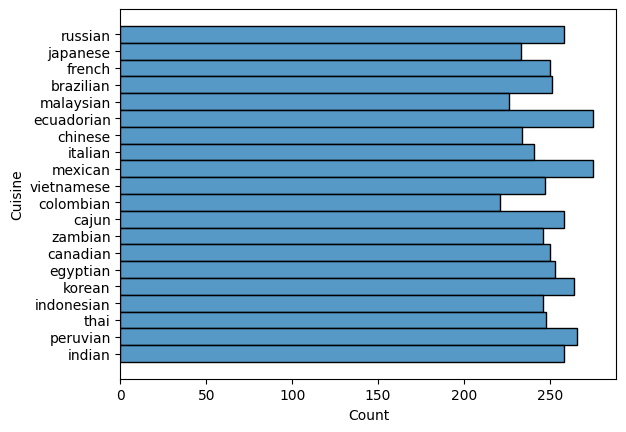

In [31]:
sns.histplot(data=df, y="Cuisine")

In [33]:
import plotly.express as px
fig = px.histogram(df, x="Cuisine")
fig.show()

Select restaurants serving 'italian' cuisine.

In [35]:
df_italian = df.query("Cuisine == 'italian'").copy()
df_italian[:5]

,Name,Lon,Lat,Rid,Cuisine
10,Wild Asia,-73.878611,40.850288,10,italian
28,The Country Cafe,-74.008536,40.706205,28,italian
49,Spoon Bread Catering,-73.960841,40.801431,49,italian
60,B & M Hot Bagel & Grocery,-74.152359,40.556376,60,italian
106,Spain Restaurant & Bar,-73.997921,40.737134,106,italian


Select restaurants serving 'french' cuisine.

In [36]:
df_french = df.query("Cuisine == 'french'").copy()
df_french[:5]

,Name,Lon,Lat,Rid,Cuisine
2,Riviera Caterer,-73.982420,40.579505,2,french
54,Philadelhia Grille Express,-74.034005,40.612708,54,french
91,Corner Bistro,-74.003782,40.738012,91,french
115,Jahn'S Restaurant,-73.885002,40.749427,115,french
154,Blarney Stone,-74.013701,40.706203,154,french


Let's build a small dataset.

In [40]:
df_test = pd.concat([df_italian[:6], df_french[:6]],ignore_index=True)
df_test

,Name,Lon,Lat,Rid,Cuisine
0,Wild Asia,-73.878611,40.850288,10,italian
1,The Country Cafe,-74.008536,40.706205,28,italian
2,Spoon Bread Catering,-73.960841,40.801431,49,italian
3,B & M Hot Bagel & Grocery,-74.152359,40.556376,60,italian
4,Spain Restaurant & Bar,-73.997921,40.737134,106,italian
5,Lenihan'S Saloon,-73.827705,40.694463,139,italian
6,Riviera Caterer,-73.982420,40.579505,2,french
7,Philadelhia Grille Express,-74.034005,40.612708,54,french
8,Corner Bistro,-74.003782,40.738012,91,french
9,Jahn'S Restaurant,-73.885002,40.749427,115,french


Add location of each restaurant to Redis.

In [41]:
def add2GeoIndex(r,keyv,lat,lon,name):
    r.geoadd(keyv,(lon,lat,name))

In [46]:
keyv = "restaurant_locations"
for i in range(0,len(df_test)):
    #print(f"{i+1} = {df_test.at[i,'Cuisine']} ")
    name=f"{df_test.at[i,'Rid']}@rid"
    print(f"{keyv}, ({df_test.at[i,'Lat']},{df_test.at[i,'Lon']},{name})")
    add2GeoIndex(r,keyv,float(df_test.at[i,'Lat']),float(df_test.at[i,'Lon']),name)


restaurant_locations, (40.8502883,-73.8786113,10@rid)
restaurant_locations, (40.70620539999999,-74.0085357,28@rid)
restaurant_locations, (40.8014307,-73.96084119999999,49@rid)
restaurant_locations, (40.5563756,-74.15235919999999,60@rid)
restaurant_locations, (40.7371344,-73.9979214,106@rid)
restaurant_locations, (40.6944628,-73.82770529999999,139@rid)
restaurant_locations, (40.579505,-73.98241999999999,2@rid)
restaurant_locations, (40.6127077,-74.03400479999999,54@rid)
restaurant_locations, (40.7380122,-74.0037823,91@rid)
restaurant_locations, (40.7494272,-73.8850023,115@rid)
restaurant_locations, (40.7062029,-74.0137007,154@rid)
restaurant_locations, (40.768019,-73.9550129,199@rid)


Other attributes of each restaurant is cached as a hashset.

In [ ]:
for i in range(0,len(df_test)):
    name=f"{df_test.at[i,'Rid']}@rid"
    print(f"HSET {name}  cuisine {df_test.at[i,'Cuisine']}")
    r.hset(name,"cuisine",df_test.at[i,'Cuisine'])

Let's find out restaurants within the given radius ;

Query:  *find the list of restaurants that serve $cuisine and **is within Xkm from a location (Lat, Lon)***


In [53]:
ans=r.geosearch("restaurant_locations" ,
            longitude=-73.9608,
            latitude=40.8014,
            radius=8000,
            unit="m",
            sort="ASC")

In [54]:
ans

[b'49@rid', b'199@rid', b'106@rid', b'91@rid']

In [75]:
list_rid = []
for a in ans:
    list_rid.append(int(a.decode('utf-8').split("@rid")[0]))
list_rid

[49, 199, 106, 91]

Let's see details of each restaurant from the test data.

In [76]:
df_select  = df_test.query('Rid in @list_rid').copy()
df_select

,Name,Lon,Lat,Rid,Cuisine
2,Spoon Bread Catering,-73.960841,40.801431,49,italian
4,Spain Restaurant & Bar,-73.997921,40.737134,106,italian
8,Corner Bistro,-74.003782,40.738012,91,french
11,Malaga Restaurant,-73.955013,40.768019,199,french


System needs to filter based on Cuisine value.

In [88]:
ans_rid = []
for a in ans:
    ans_rid.append(a.decode('utf-8'))
ans_rid

['49@rid', '199@rid', '106@rid', '91@rid']

Using hashset of each restaurant to filter.

In [100]:
def filter_by_cuisine(r, ridKeys, label, expected):
    reply_rids = []
    for rid in ridKeys:
        try:
            val = r.hget(rid, "cuisine")
            if val.decode('utf-8') == expected:
                reply_rids.append(rid)
        except e:
            pass
    return reply_rids


In [101]:
final_ans = filter_by_cuisine(r,ans_rid,"cuisine","italian")
final_ans

['49@rid', '106@rid']

Now, the second query removed restaurants that do not serve 'italian' cuisine.

In [103]:
rids = [ int(r.split('@rid')[0]) for r in final_ans]
rids

[49, 106]

In [104]:
df_final  = df_test.query('Rid in @rids').copy()
df_final

,Name,Lon,Lat,Rid,Cuisine
2,Spoon Bread Catering,-73.960841,40.801431,49,italian
4,Spain Restaurant & Bar,-73.997921,40.737134,106,italian


Above final result lists the final answer to the given query.

When we analyze,
- 1 geosearch()
- M hget() where M is the number of restaurants returned by the NN query.


Bexause of the second step, it will be efficient to write this query as a Lua script and run it at one request.

# Lua Scripting

The first one is executing a command that does not require any key and arguments.

In [108]:
lua_txt="return redis.call('keys','*')"
reply = r.eval(lua_txt,0)
reply

[b'49@rid',
 b'154@rid',
 b'user:name',
 b'54@rid',
 b'106@rid',
 b'drivers',
 b'139@rid',
 b'10@rid',
 b'28@rid',
 b'60@rid',
 b'user:name2',
 b'2@rid',
 b'91@rid',
 b'115@rid',
 b'restaurant_locations',
 b'199@rid']

Let's implement HGET call to retrieve the value of field ('cuisine').

In [109]:
lua_txt="return redis.call('hget',KEYS[1], ARGV[1])"
reply = r.eval(lua_txt,1,'91@rid','cuisine')
reply

b'french'

Let's implement GEOSEARCH

In [118]:
lua_txt="""
local key = KEYS[1]
local lon = tonumber(ARGV[1])
local lat = tonumber(ARGV[2])
local radius = tonumber(ARGV[3])
local unit = ARGV[4]
return redis.call('geosearch', key,'FROMLONLAT', lon, lat, 'BYRADIUS', radius, unit)
"""
reply = r.eval(lua_txt,1,'restaurant_locations', -73.9608, 40.8014, 8000, 'm')
reply

[b'49@rid', b'91@rid', b'106@rid', b'199@rid']

Let's put these into one Lua script.

In [122]:
lua_txt="""
local key = KEYS[1]
local lon = tonumber(ARGV[1])
local lat = tonumber(ARGV[2])
local radius = tonumber(ARGV[3])
local unit = ARGV[4]
local select_cuisine = ARGV[5]

local nnq =  redis.call('geosearch', key,'FROMLONLAT', lon, lat, 'BYRADIUS', radius, unit)
local query_response = {}

for i, rid in ipairs(nnq) do
    local serves = redis.call('hget',rid, 'cuisine')
    if serves == select_cuisine then
        table.insert(query_response,rid)
    end
end

return query_response
"""
reply = r.eval(lua_txt,1,'restaurant_locations', -73.9608, 40.8014, 8000, 'm','italian')
reply

[b'49@rid', b'106@rid']

In [124]:
rids = [ int(r.decode('utf-8').split('@rid')[0]) for r in reply]
df_final  = df_test.query('Rid in @rids').copy()
df_final

,Name,Lon,Lat,Rid,Cuisine
2,Spoon Bread Catering,-73.960841,40.801431,49,italian
4,Spain Restaurant & Bar,-73.997921,40.737134,106,italian


# Summary
This notebook demonstrated how to implement the following query by using Redis.


The first implementation required additional Redis calls to implement filtering step.
Therefore,  it explored using Lua script and executing both steps in Redis server.